# 1. INSTALASI DAN IMPORT LIBRARY

In [1]:
import sys
import subprocess
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline  # Gunakan sklearn Pipeline untuk tanpa SMOTE
from imblearn.over_sampling import SMOTE
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


# 2. LOAD DATASET

In [2]:
def load_dataset():
    """Load dan validasi dataset"""
    try:
        df = pd.read_csv('../dataset/dataset_structured.csv')
        
        # Pemeriksaan kolom
        expected_columns = ['sentimen', 'emosi', 'ulasan']
        if not all(col in df.columns for col in expected_columns):
            raise ValueError(f"Dataset harus memiliki kolom: {expected_columns}")
        
        # Hapus baris dengan nilai kosong
        df = df.dropna()
        
        print("Dataset loaded successfully.")
        print(f"Total data: {len(df)}")
        print("Kolom dataset:", df.columns.tolist())
        print("\nDistribusi Sentimen:")
        print(df['sentimen'].value_counts())
        print("\nDistribusi Emosi:")
        print(df['emosi'].value_counts())
        
        return df
    except FileNotFoundError:
        print("Error: File dataset tidak ditemukan!")
        return None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

# 3. TEXT PREPROCESSING

In [3]:
def setup_preprocessing():
    """Setup preprocessing tools"""
    try:
        # Load slang dictionary
        slang_df = pd.read_csv('../dataset/slang_indo.csv', header=None, names=['slang', 'formal'])
        slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))
        
        # Load stopwords
        with open('../dataset/stopwords-id.txt', 'r') as f:
            stopwords = set(f.read().splitlines())
            
        # Tambahan slang dictionary
        additional_slang = {
            'burik': 'jelek', 'anjs': 'anjing', 'goblok': 'bodoh',
            'kontol': 'kasar', 'sialan': 'kasar', 'anjg': 'anjing',
            'bgs': 'bagus', 'bgt': 'banget', 'bnyk': 'banyak',
            'bsk': 'besok', 'byk': 'banyak', 'dmn': 'dimana',
            'gmn': 'gimana', 'jd': 'jadi', 'jg': 'juga',
            'klo': 'kalau', 'kyk': 'seperti', 'lg': 'lagi',
            'mngkn': 'mungkin', 'msh': 'masih', 'nggak': 'tidak',
            'ngga': 'tidak', 'pdhl': 'padahal', 'pny': 'punya',
            'sbnrnya': 'sebenarnya', 'sdh': 'sudah', 'skrg': 'sekarang',
            'sm': 'sama', 'spt': 'seperti', 'sy': 'saya',
            'tdk': 'tidak', 'tp': 'tapi', 'udh': 'sudah',
            'utk': 'untuk', 'yg': 'yang'
        }
        slang_dict.update(additional_slang)
        
        # Setup stemmer
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        
        return slang_dict, stopwords, stemmer
        
    except FileNotFoundError as e:
        print(f"Error: File preprocessing tidak ditemukan - {e}")
        # Fallback jika file tidak ada
        return {}, set(), StemmerFactory().create_stemmer()
    except Exception as e:
        print(f"Error setup preprocessing: {e}")
        return {}, set(), StemmerFactory().create_stemmer()

def preprocess_text(text, slang_dict, stopwords, stemmer):
    """Preprocessing teks lengkap"""
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to string dan lowercase
    text = str(text).lower()
    
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Hapus mention dan hashtag
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Hapus kode transaksi dan ID
    text = re.sub(r'\b\d+[a-zA-Z]+\d+\b', '', text)
    
    # Hapus tanda baca dan karakter khusus (kecuali spasi)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Skip jika text kosong
    if not text:
        return ''
    
    # Normalisasi slang
    words = text.split()
    words = [slang_dict.get(word, word) for word in words]
    
    # Hapus kata yang diulang berurutan
    result_words = []
    for i, word in enumerate(words):
        if i == 0 or word != words[i-1]:
            result_words.append(word)
    
    # Hapus stopwords
    words = [word for word in result_words if word not in stopwords and len(word) > 2]
    
    if not words:
        return ''
    
    text = ' '.join(words)
    
    # Stemming
    try:
        text = stemmer.stem(text)
    except:
        pass  # Jika stemming gagal, lanjut tanpa stemming
    
    return text

# 4. MODEL TRAINING CLASS

In [4]:
class SentimentEmotionClassifier:
    def __init__(self):
        self.sentiment_model = None
        self.emotion_model = None
        self.vectorizer_sent = None
        self.vectorizer_emo = None
        self.preprocessing_tools = None
        
    def setup_preprocessing(self):
        """Setup preprocessing tools"""
        self.preprocessing_tools = setup_preprocessing()
        
    def preprocess_data(self, df):
        """Preprocess seluruh dataset"""
        slang_dict, stopwords, stemmer = self.preprocessing_tools
        
        print("Memulai preprocessing teks...")
        df['cleaned_review'] = df['ulasan'].apply(
            lambda x: preprocess_text(x, slang_dict, stopwords, stemmer)
        )
        
        # Hapus data dengan teks kosong setelah preprocessing
        initial_count = len(df)
        df = df[df['cleaned_review'].str.len() > 0].copy()
        final_count = len(df)
        
        print(f"Preprocessing selesai. Data tersisa: {final_count}/{initial_count}")
        return df
        
    def prepare_data(self, df):
        """Pisahkan data untuk training dan testing"""
        print("Memisahkan data training dan testing...")
        
        # Untuk sentimen
        X_sentiment = df['cleaned_review']
        y_sentiment = df['sentimen']
        X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
            X_sentiment, y_sentiment, test_size=0.2, random_state=42, 
            stratify=y_sentiment
        )
        
        # Untuk emosi
        X_emotion = df['cleaned_review']
        y_emotion = df['emosi']
        X_train_emo, X_test_emo, y_train_emo, y_test_emo = train_test_split(
            X_emotion, y_emotion, test_size=0.2, random_state=42, 
            stratify=y_emotion
        )
        
        print(f"Data sentimen - Training: {len(X_train_sent)}, Testing: {len(X_test_sent)}")
        print(f"Data emosi - Training: {len(X_train_emo)}, Testing: {len(X_test_emo)}")
        
        return (X_train_sent, X_test_sent, y_train_sent, y_test_sent,
                X_train_emo, X_test_emo, y_train_emo, y_test_emo)
    
    def train_models(self, X_train_sent, y_train_sent, X_train_emo, y_train_emo):
        """Training model dengan hyperparameter tuning"""
        print("\n" + "="*50)
        print("MEMULAI TRAINING MODEL")
        print("="*50)
        
        # Setup vectorizers
        self.vectorizer_sent = TfidfVectorizer(
            max_features=5000, 
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        )
        
        self.vectorizer_emo = TfidfVectorizer(
            max_features=5000, 
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        )
        
        # Transform data
        print("Mengekstrak fitur dengan TF-IDF...")
        X_train_sent_tfidf = self.vectorizer_sent.fit_transform(X_train_sent)
        X_train_emo_tfidf = self.vectorizer_emo.fit_transform(X_train_emo)
        
        # Apply SMOTE untuk mengatasi imbalanced data
        print("Menerapkan SMOTE untuk balancing data...")
        smote = SMOTE(random_state=42)
        
        X_train_sent_balanced, y_train_sent_balanced = smote.fit_resample(
            X_train_sent_tfidf, y_train_sent
        )
        X_train_emo_balanced, y_train_emo_balanced = smote.fit_resample(
            X_train_emo_tfidf, y_train_emo
        )
        
        print(f"Setelah SMOTE - Sentimen: {X_train_sent_balanced.shape[0]} samples")
        print(f"Setelah SMOTE - Emosi: {X_train_emo_balanced.shape[0]} samples")
        
        # Parameter grid untuk tuning
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
        
        # Training sentiment model
        print("\nTraining model sentimen...")
        svm_sent = SVC(probability=True, random_state=42)
        grid_search_sent = GridSearchCV(
            svm_sent, param_grid, cv=5, 
            scoring='f1_weighted', n_jobs=-1, verbose=1
        )
        grid_search_sent.fit(X_train_sent_balanced, y_train_sent_balanced)
        
        self.sentiment_model = grid_search_sent.best_estimator_
        print(f"Best parameters for sentiment: {grid_search_sent.best_params_}")
        print(f"Best CV score for sentiment: {grid_search_sent.best_score_:.4f}")
        
        # Training emotion model
        print("\nTraining model emosi...")
        svm_emo = SVC(probability=True, random_state=42)
        grid_search_emo = GridSearchCV(
            svm_emo, param_grid, cv=5, 
            scoring='f1_weighted', n_jobs=-1, verbose=1
        )
        grid_search_emo.fit(X_train_emo_balanced, y_train_emo_balanced)
        
        self.emotion_model = grid_search_emo.best_estimator_
        print(f"Best parameters for emotion: {grid_search_emo.best_params_}")
        print(f"Best CV score for emotion: {grid_search_emo.best_score_:.4f}")
        
        print("\nTraining selesai!")
        
    def evaluate_models(self, X_test_sent, y_test_sent, X_test_emo, y_test_emo):
        """Evaluasi model pada data testing"""
        print("\n" + "="*50)
        print("EVALUASI MODEL")
        print("="*50)
        
        # Transform test data
        X_test_sent_tfidf = self.vectorizer_sent.transform(X_test_sent)
        X_test_emo_tfidf = self.vectorizer_emo.transform(X_test_emo)
        
        # Prediksi
        y_pred_sent = self.sentiment_model.predict(X_test_sent_tfidf)
        y_pred_emo = self.emotion_model.predict(X_test_emo_tfidf)
        
        # Evaluasi Sentimen
        print("HASIL EVALUASI SENTIMEN:")
        print("-" * 30)
        print(f"Accuracy: {accuracy_score(y_test_sent, y_pred_sent):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test_sent, y_pred_sent))
        
        # Evaluasi Emosi
        print("\nHASIL EVALUASI EMOSI:")
        print("-" * 30)
        print(f"Accuracy: {accuracy_score(y_test_emo, y_pred_emo):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test_emo, y_pred_emo))
        
        # Confusion Matrix
        self._plot_confusion_matrix(y_test_sent, y_pred_sent, "Sentimen")
        self._plot_confusion_matrix(y_test_emo, y_pred_emo, "Emosi")
        
        return y_pred_sent, y_pred_emo
    
    def _plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=np.unique(y_true), 
                   yticklabels=np.unique(y_true))
        plt.title(f'Confusion Matrix - {title}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{title.lower()}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def save_models(self, filepath_sent='sentiment_model.pkl', filepath_emo='emotion_model.pkl'):
        """Simpan model dan vectorizer"""
        print("\nMenyimpan model...")
        
        # Simpan model sentimen beserta vectorizer
        with open(filepath_sent, 'wb') as f:
            pickle.dump({
                'model': self.sentiment_model,
                'vectorizer': self.vectorizer_sent,
                'preprocessing_tools': self.preprocessing_tools
            }, f)
        
        # Simpan model emosi beserta vectorizer
        with open(filepath_emo, 'wb') as f:
            pickle.dump({
                'model': self.emotion_model,
                'vectorizer': self.vectorizer_emo,
                'preprocessing_tools': self.preprocessing_tools
            }, f)
            
        print(f"Model berhasil disimpan:")
        print(f"- Sentimen: {filepath_sent}")
        print(f"- Emosi: {filepath_emo}")
    
    def predict_new_review(self, review_text):
        """Prediksi sentimen dan emosi untuk ulasan baru"""
        if not self.sentiment_model or not self.emotion_model:
            raise ValueError("Model belum ditraining! Jalankan training terlebih dahulu.")
        
        # Preprocessing
        slang_dict, stopwords, stemmer = self.preprocessing_tools
        cleaned_review = preprocess_text(review_text, slang_dict, stopwords, stemmer)
        
        if not cleaned_review:
            return {'sentiment': 'Unknown', 'emotion': 'Unknown', 'confidence': 0.0}
        
        # Transform dengan vectorizer
        review_sent_tfidf = self.vectorizer_sent.transform([cleaned_review])
        review_emo_tfidf = self.vectorizer_emo.transform([cleaned_review])
        
        # Prediksi
        sentiment = self.sentiment_model.predict(review_sent_tfidf)[0]
        emotion = self.emotion_model.predict(review_emo_tfidf)[0]
        
        # Confidence score
        sent_proba = self.sentiment_model.predict_proba(review_sent_tfidf)[0].max()
        emo_proba = self.emotion_model.predict_proba(review_emo_tfidf)[0].max()
        
        return {
            'original_text': review_text,
            'cleaned_text': cleaned_review,
            'sentiment': sentiment,
            'emotion': emotion,
            'sentiment_confidence': sent_proba,
            'emotion_confidence': emo_proba
        }

# 5. MAIN EXECUTION

In [5]:
def main():
    """Fungsi utama untuk menjalankan seluruh proses"""
    print("STARTING SENTIMENT AND EMOTION CLASSIFICATION")
    print("=" * 60)
    
    # 1. Load dataset
    df = load_dataset()
    if df is None:
        return
    
    # 2. Initialize classifier
    classifier = SentimentEmotionClassifier()
    classifier.setup_preprocessing()
    
    # 3. Preprocessing
    df = classifier.preprocess_data(df)
    
    # 4. Prepare data
    data_splits = classifier.prepare_data(df)
    X_train_sent, X_test_sent, y_train_sent, y_test_sent, X_train_emo, X_test_emo, y_train_emo, y_test_emo = data_splits
    
    # 5. Train models
    classifier.train_models(X_train_sent, y_train_sent, X_train_emo, y_train_emo)
    
    # 6. Evaluate models
    classifier.evaluate_models(X_test_sent, y_test_sent, X_test_emo, y_test_emo)
    
    # 7. Save models
    classifier.save_models()
    
    # 8. Test prediction dengan contoh
    print("\n" + "="*50)
    print("TESTING PREDIKSI ULASAN BARU")
    print("="*50)
    
    test_reviews = [
        "Aplikasi ini burik banget, gk bisa login!",
        "Mantap banget gamenya, seru abis!",
        "Biasa aja sih, tidak terlalu istimewa",
        "Sangat mengecewakan, banyak bug",
        "Bagus tapi perlu improvement di beberapa fitur"
    ]
    
    for review in test_reviews:
        result = classifier.predict_new_review(review)
        print(f"\nUlasan: '{result['original_text']}'")
        print(f"Sentimen: {result['sentiment']} (confidence: {result['sentiment_confidence']:.3f})")
        print(f"Emosi: {result['emotion']} (confidence: {result['emotion_confidence']:.3f})")
    
    return classifier

# 6. UTILITY FUNCTIONS

STARTING SENTIMENT AND EMOTION CLASSIFICATION
Dataset loaded successfully.
Total data: 21150
Kolom dataset: ['sentimen', 'emosi', 'ulasan']

Distribusi Sentimen:
sentimen
Negative    7492
Neutral     7306
Positive    6352
Name: count, dtype: int64

Distribusi Emosi:
emosi
Neutral    7306
Happy      6166
Sad        3662
Anger      2612
Fear       1218
Love        186
Name: count, dtype: int64
Memulai preprocessing teks...
Preprocessing selesai. Data tersisa: 20937/21150
Memisahkan data training dan testing...
Data sentimen - Training: 16749, Testing: 4188
Data emosi - Training: 16749, Testing: 4188

MEMULAI TRAINING MODEL
Mengekstrak fitur dengan TF-IDF...
Menerapkan SMOTE untuk balancing data...
Setelah SMOTE - Sentimen: 17907 samples
Setelah SMOTE - Emosi: 34260 samples

Training model sentimen...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for sentiment: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score for sentiment: 0.7280

Training model em

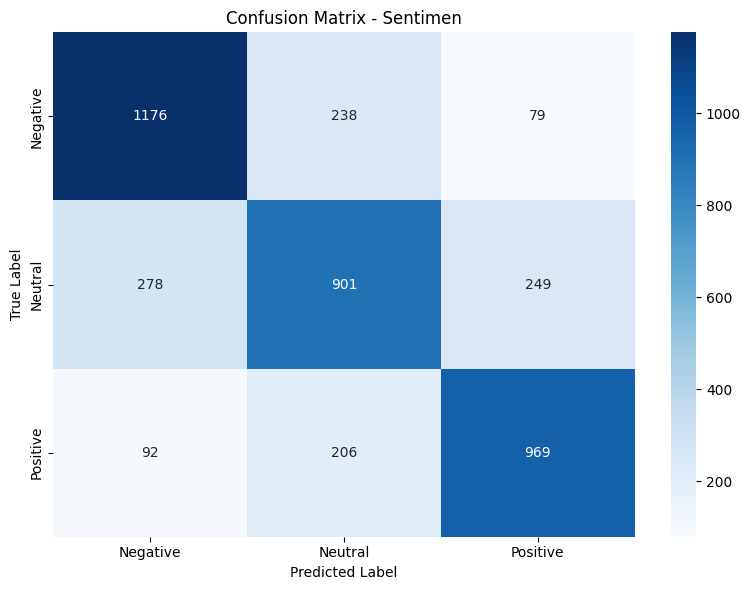

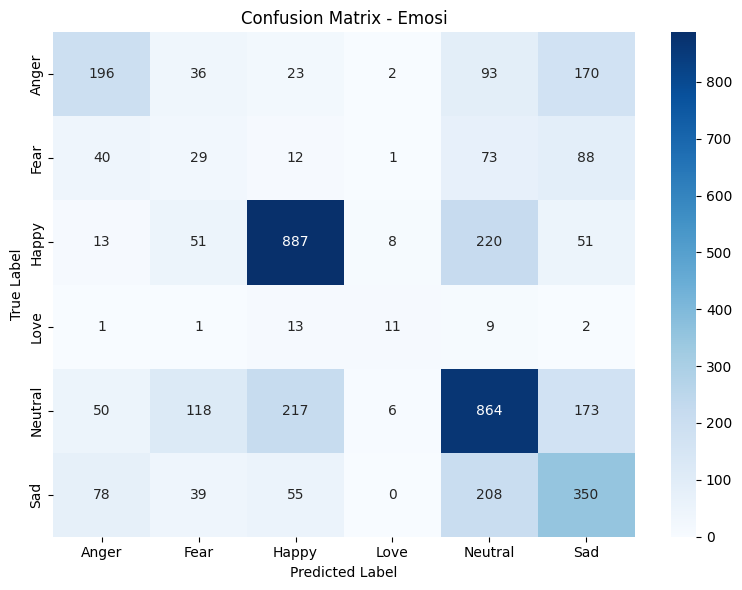


Menyimpan model...
Model berhasil disimpan:
- Sentimen: sentiment_model.pkl
- Emosi: emotion_model.pkl

TESTING PREDIKSI ULASAN BARU

Ulasan: 'Aplikasi ini burik banget, gk bisa login!'
Sentimen: Negative (confidence: 0.937)
Emosi: Anger (confidence: 0.591)

Ulasan: 'Mantap banget gamenya, seru abis!'
Sentimen: Positive (confidence: 0.956)
Emosi: Happy (confidence: 0.959)

Ulasan: 'Biasa aja sih, tidak terlalu istimewa'
Sentimen: Neutral (confidence: 0.546)
Emosi: Neutral (confidence: 0.887)

Ulasan: 'Sangat mengecewakan, banyak bug'
Sentimen: Negative (confidence: 0.992)
Emosi: Sad (confidence: 0.985)

Ulasan: 'Bagus tapi perlu improvement di beberapa fitur'
Sentimen: Positive (confidence: 0.691)
Emosi: Happy (confidence: 0.769)


In [6]:
def load_trained_model(filepath_sent='sentiment_model.pkl', filepath_emo='emotion_model.pkl'):
    """Load model yang sudah ditraining"""
    try:
        with open(filepath_sent, 'rb') as f:
            sent_data = pickle.load(f)
        
        with open(filepath_emo, 'rb') as f:
            emo_data = pickle.load(f)
        
        classifier = SentimentEmotionClassifier()
        classifier.sentiment_model = sent_data['model']
        classifier.vectorizer_sent = sent_data['vectorizer']
        classifier.emotion_model = emo_data['model']
        classifier.vectorizer_emo = emo_data['vectorizer']
        classifier.preprocessing_tools = sent_data['preprocessing_tools']
        
        print("Model berhasil dimuat!")
        return classifier
        
    except FileNotFoundError:
        print("Error: File model tidak ditemukan!")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Jalankan jika dipanggil langsung
if __name__ == "__main__":
    classifier = main()